In [1]:
import cupy as cp
import numpy as np
import time

%load_ext autoreload
%autoreload 2

In [ ]:
### Numpy and CPU
s = time.time()
x_cpu = np.ones((4000,100,1))
e = time.time()
print(e - s)

In [ ]:
### CuPy and GPU
s = time.time()
x_gpu = cp.ones((4000,1))
cp.cuda.Stream.null.synchronize()
e = time.time()
print(e - s)

In [2]:
from bprH_gpu import bprH, save_model, load_model
import pandas as pd
from sklearn.model_selection import KFold, train_test_split
import cProfile as profile

In [8]:
def behavior_generator(num_user = 10, num_item=10):
    data = []
    for u in range(num_user):
        for i in range(num_item):
            p = np.random.uniform(0,1)
            if 0.99 <= p:
                data.append(['U' + str(u),'I' + str(i),'P'])
            elif 0.9 <= p:
                data.append(['U' + str(u),'I' + str(i),'P'])
                data.append(['U' + str(u),'I' + str(i),'V'])
            elif 0.7 <= p:
                data.append(['U' + str(u),'I' + str(i),'V'])
    data = pd.DataFrame(data, columns=['UserID', 'ItemID', 'Action'])
    return data

In [9]:
data = behavior_generator(num_user=500, num_item=900)

In [ ]:
# to librec
data_librec_1 = data[data.Action == 'P']
data_librec_1.Action = 1
data_librec_1.to_csv('generated_data.txt', index=False, header=False)

data_librec_2 = data
data_librec_1.Action = 1
data_librec_1.to_csv('generated_data2.txt', index=False, header=False)

In [10]:
# the best way is to split the data with a time manner - from sklearn.model_selection import TimeSeriesSplit
# but first let's do it in a simple way

original_item_list = sorted(set(data.ItemID))
original_user_list = sorted(set(data.UserID))

data_without_target = data[data.Action != 'P']
data_only_with_target = data[data.Action == 'P']

In [11]:
# split the data_only_with_target into 5 folds
#kf = KFold(n_splits=5,shuffle=True, random_state=0)
#kf.get_n_splits(X=data_only_with_target)

d1, test_data = train_test_split(data_only_with_target, test_size=0.2)

train_data = pd.concat([d1, data_without_target])
train_data.reset_index(inplace=True, drop=True)
test_data.reset_index(inplace=True, drop=True)

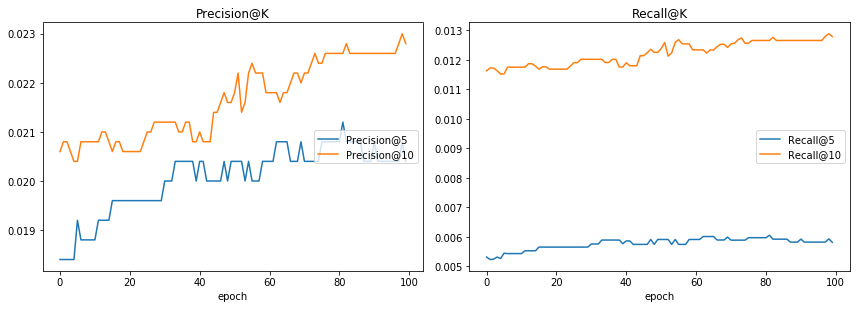


100%|██████████| 10000/10000 [13:52<00:00, 12.01it/s, est_changed=0.7512530207661374, len_I=57, len_J=174, len_K=596]


Precision@K
	Precision@5      	 (min:    0.018, max:    0.021, cur:    0.020)
	Precision@10     	 (min:    0.020, max:    0.023, cur:    0.023)
Recall@K
	Recall@5         	 (min:    0.005, max:    0.006, cur:    0.006)
	Recall@10        	 (min:    0.012, max:    0.013, cur:    0.013)


In [12]:
#pr = profile.Profile()
#pr.enable()
bprh_model = bprH(dim=25,
                 omega=1000,
                 rho=1,
                 lambda_u=0.00001,
                 lambda_v=0.00001,
                 lambda_b=0.00001,
                 gamma=0.1,
                 random_state=20200710,
                 num_iter=10000)

bprh_model.fit(X=train_data,
          eval_X=test_data,
          original_item_list=original_item_list,
          original_user_list=original_user_list,
          saved_path='data/item-set-coselection-test.pkl',
          correlation=True,
          coselection=True,
          plot_metric=True,
          log_metric=True
)
#pr.disable()
#pr.dump_stats("bhrH_gpu_profile.pstat")

In [13]:
scoring_list, p, r, _ = bprh_model.scoring(ground_truth=bprh_model.test_data,
                                      K=10,
                                      train_data_as_reference_flag=True)
print('Recall: test %.4f.' % r)
print('Precision: test %.4f.' % p)

Recall: test 0.0129.
Precision: test 0.0230.


In [14]:
scoring_list, p, r, _ = bprh_model.scoring(ground_truth=bprh_model.train_data,
                                      K=10,
                                      train_data_as_reference_flag=False)
print('Recall: train %.4f.' % r)
print('Precision: train %.4f.' % p)

Recall: train 0.0110.
Precision: train 0.0792.


In [ ]:
import numpy as np
import scipy

In [ ]:
lfm_train_data = np.zeros(shape=(800,1280))
lfm_test_data = np.zeros(shape=(800,1280))
for u in original_user_list:
    train_item_pool = set(train_data[(train_data.UserID == u) & (train_data.Action == 'P')].ItemID)
    test_item_pool = set(test_data[(test_data.UserID == u) & (test_data.Action == 'P')].ItemID)
    u_idx = original_user_list.index(u)
    for i in train_item_pool:
        i_idx = original_item_list.index(i)
        lfm_train_data[u_idx,i_idx] = 1
    for i in test_item_pool:
        i_idx = original_item_list.index(i)
        lfm_test_data[u_idx,i_idx] = 1

In [ ]:
lfm_train_data = scipy.sparse.coo_matrix(lfm_train_data)
lfm_test_data = scipy.sparse.coo_matrix(lfm_test_data)

In [ ]:
from lightfm import LightFM
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import recall_at_k
from lightfm.evaluation import auc_score

In [ ]:
bpr_model = LightFM(no_components=15,
                learning_rate=0.005,
                loss='bpr',
                user_alpha=0.00001,
                item_alpha=0.00001,
                random_state=20200711)

bpr_model.fit(lfm_train_data, epochs=600)

In [ ]:
train_recall = recall_at_k(bpr_model, lfm_train_data, k=10).mean()
test_recall = recall_at_k(bpr_model, lfm_test_data, k=10).mean()

train_precision = precision_at_k(bpr_model, lfm_train_data, k=10).mean()
test_precision = precision_at_k(bpr_model, lfm_test_data, k=10).mean()

train_auc = auc_score(bpr_model, lfm_train_data).mean()
test_auc = auc_score(bpr_model, lfm_test_data).mean()

print('Recall: train %.4f, test %.4f.' % (train_recall, test_recall))
print('Precision: train %.4f, test %.4f.' % (train_precision, test_precision))
print('AUC: train %.4f, test %.4f.' % (train_auc, test_auc))

In [ ]:
kf = KFold(n_splits=5,shuffle=True, random_state=0)
kf.get_n_splits(X=data_only_with_target)

cnt = 0
for train_index, test_index in kf.split(X=data_only_with_target):
    # build train and test data
    # page 90 5.2 section - make most of auxiliary data in training process
    train_data = pd.concat([data_only_with_target.iloc[train_index], data_without_target])
    test_data = data_only_with_target.iloc[test_index]

    # start a BPRH model
    model = bprH(dim=8,
                 omega=1,
                 rho=1,
                 lambda_u=1.5,
                 lambda_v=0.1,
                 lambda_b=0.1,
                 gamma=0.01,
                 random_state=20200704,
                 num_iter=9000)

    model.fit(X=train_data,
              eval_X=test_data,
              original_item_list=original_item_list,
              original_user_list=original_user_list,
              saved_path='data/item-set-coselection-'+str(cnt)+'.pkl',
              coselection=True,
              plot_metric=True)
    cnt += 1


In [ ]:
# read sobazaar data
data = pd.read_csv('data/sb_bprh.csv')
# change column name
data.columns = ['ItemID', 'UserID', 'Action', 'Action_Date', 'Action_Time',
       'SessionID']

data = data[['ItemID', 'UserID', 'Action']]
data.drop_duplicates(inplace=True)

In [ ]:
# the best way is to split the data with a time manner - from sklearn.model_selection import TimeSeriesSplit
# but first let's do it in a simple way

original_item_list = sorted(set(data.ItemID))
original_user_list = sorted(set(data.UserID))

data_without_target = data[data.Action != 'P']
data_only_with_target = data[data.Action == 'P']

In [ ]:
# split the data_only_with_target into 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=0)
kf.get_n_splits(X=data_only_with_target)

In [ ]:
cnt = 0
for train_index, test_index in kf.split(X=data_only_with_target):
    # build train and test data
    train_data = pd.concat([data_only_with_target.iloc[train_index], data_without_target])
    test_data = data_only_with_target.iloc[test_index]

    # start a BPRH model
    model = bprH(dim=30,
                 omega=1000,
                 rho=1,
                 lambda_u=1,
                 lambda_v=0.5,
                 lambda_b=0.5,
                 gamma=0.01,
                 random_state=20200704,
                 num_iter=10000)

    model.fit(X=train_data,
              eval_X=test_data,
              original_item_list=original_item_list,
              original_user_list=original_user_list,
              saved_path='data/item-set-coselection-'+str(cnt)+'.pkl',
              coselection=True,
              plot_metric=True)
    cnt += 1

In [ ]:
d1, test_data = train_test_split(data_only_with_target, test_size=0.2)

train_data = pd.concat([d1, data_without_target])
train_data.reset_index(inplace=True,drop=True)
test_data.reset_index(inplace=True,drop=True)

In [ ]:
bprh_model = bprH(dim=50,
                 omega=1000,
                 rho=1,
                 lambda_u=0.00001,
                 lambda_v=0.00001,
                 lambda_b=0.00001,
                 gamma=0.1,
                 random_state=20200710,
                 num_iter=10000)

bprh_model.fit(X=train_data,
          eval_X=test_data,
          original_item_list=original_item_list,
          original_user_list=original_user_list,
          saved_path='data/item-set-coselection-test.pkl',
          correlation=True,
          coselection=True,
          plot_metric=True,
          log_metric=True)

In [ ]:
scoring_list, p, r, _ = bprh_model.scoring(ground_truth=bprh_model.test_data,
                                      K=10,
                                      train_data_as_reference_flag=True)
print('Recall: test %.4f.' % r)
print('Precision: test %.4f.' % p)

In [ ]:
scoring_list, p, r, _ = bprh_model.scoring(ground_truth=bprh_model.train_data,
                                      K=10,
                                      train_data_as_reference_flag=False)
print('Recall: train %.4f.' % r)
print('Precision: train %.4f.' % p)